In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.measure

import random
import copy
import math
import cv2
import os
import sys

2024-02-01 23:05:16.164840: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 23:05:16.194750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 23:05:16.194775: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 23:05:16.194793: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 23:05:16.200487: I tensorflow/core/platform/cpu_feature_g

# TRAINED MODELS
## Variables definition

In [3]:
div = 32
step = int(32/4)
red = 4

map_list_t = ['master_big','master_big_closed','master_big_semiclosed']
map_root_name = 'master_big'
# map_list = ['map2','stanford_hyang10','master_big','willow','costacafe','map1','map3','stanford_coupa0', 'stanford_coupa3','stanford_hyang1','stanford_gates2']
map_list = ['stanford_hyang10','stanford_coupa0', 'stanford_coupa3','stanford_hyang1','stanford_gates2']

sem_dict = ['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree','restricted','grass','intersection']
chans = len(sem_dict)+1

lut_in = [0, 20, 50, 100, 150, 255]
lut_out = [0, 100, 180, 220, 240, 255]
lut_8u = np.interp(np.arange(0, 256), lut_in, lut_out).astype(np.uint8)

# Loading of the models

In [4]:
spec = 'stan'
date = '01feb'

model = tf.keras.models.load_model('IRI_models/'+date+'_'+str(step)+'px_steps_'+spec+'_paths')

# model1 = tf.keras.models.load_model('IRI_models/'+date+'_8px_steps_'+spec+'_vels')

# model2 = tf.keras.models.load_model('IRI_models/'+date+'_8px_steps_'+spec+'_stops')

2024-02-01 23:05:19.463908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22193 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-02-01 23:05:19.464426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22315 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:68:00.0, compute capability: 8.6
2024-02-01 23:05:22.392239: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


## Testing closed corridors (completely or partially closed)

In [5]:
# for map_name in map_list_t:
#   print(map_name)

#   lines = 0
#   with open('maps/semantics/'+map_root_name+'/'+map_name+'.csv') as f:
#     lines = f.readlines()

#   h = len(lines)
#   w = len(lines[0].split(','))

#   # Converts data to a list of integers
#   map = []
#   for line in lines:
#     map.extend([int(c) for c in line.split(',')])

#   for lab_class in sem_dict:
#     lines = 0
#     try:
#       with open('maps/semantics/'+map_root_name+'/'+map_root_name+'_sem_'+lab_class+'.csv') as f:
#         lines = f.readlines()

#       hh = len(lines)
#       ww = len(lines[0].split(','))

#       if hh != h or ww != w:
#         print(f'h: {h}\tw: {w}')
#         print(f'h: {hh}\tw: {ww}')
#         raise SystemExit("ERROR: Different sizes!!")

#       # Converts data to a list of integers
#       for line in lines:
#         map.extend([int(c) for c in line.split(',')])

#     except FileNotFoundError:
#       for i in range(h):
#         for j in range(w):
#           map.extend([255])

#   map = np.reshape(map,[chans,h,w])
#   map = np.moveaxis(map, 0, -1)
#   map = map/255

#   map_aux = map
#   map = np.zeros((int(math.ceil(h/2)),int(math.ceil(w/2)),chans))

#   for idx in range(chans):
#     map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (2,2), np.max)
#   h, w, _ = map.shape

#   diff_h = int((h-div*int(h/div))/2)
#   r_h = int((h-div*int(h/div))%2) + diff_h
#   diff_w = int((w-div*int(w/div))/2)
#   r_w = int((w-div*int(w/div))%2) + diff_w
#   map = map[r_h:-diff_h:,r_w+diff_w:,:]

#   # print(map.shape)
#   h, w, _ = map.shape

#   # -----------------------------------------------------------------------------------
#   # creating subplot and figure
#   fig = plt.figure(figsize=(w/70,h/70))
#   data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

#   step = int(32/4)
#   for i in np.arange((w/step+int(div/step-1))*(h/step+int(div/step-1))):
#     c = int(i%(w/step+int(div/step-1))) - int(div/step-1)*0
#     r = int(i/(w/step+int(div/step-1))) - int(div/step-1)*0
#     submap = map[max(step*r,0):step*r+div, max(step*c,0):step*c+div,:]
#     subdata = model.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
#     subdata = np.squeeze(subdata,axis=0)
#     data_pred[max(step*r,0):step*r+div, max(step*c,0):step*c+div] += subdata*1/(int(div/step)*int(div/step))
#   contrasted_data = cv2.LUT((data_pred/np.max(data_pred)*255).astype(np.uint8), lut_8u).astype(float)/255
#   plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(contrasted_data.shape,1),1-contrasted_data,1-contrasted_data),axis=2)), vmin=0, vmax=1)
#   # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
#   plt.show()

## Model 1 testing

stanford_hyang10
Reduced map found
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass', 'intersection']


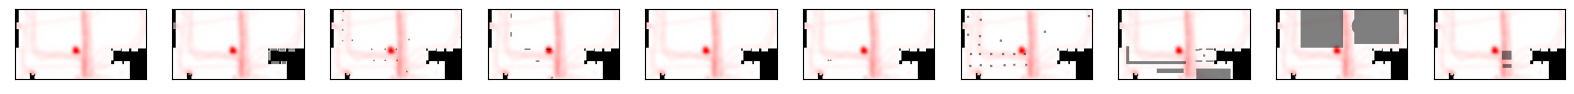

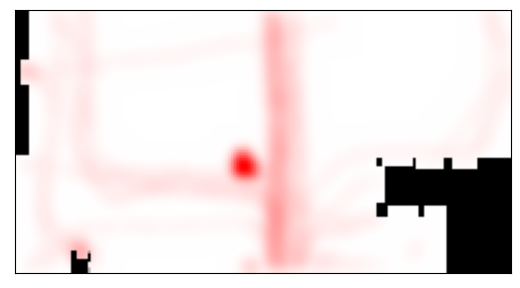

/tmp/ipykernel_1701274/1683487707.py:139: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections
2024-02-01 23:05:24.970191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-01 23:05:25.498718: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


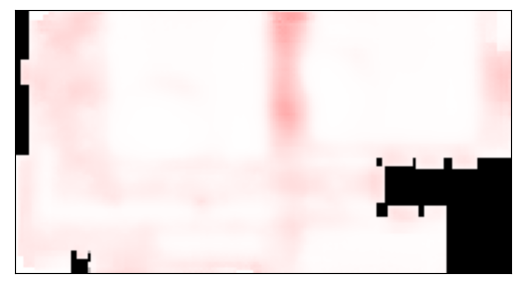

KL-divergence average: 0.7525495644785897
KL-divergence std: 0.7341958932671913
stanford_coupa0
Reduced map found
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass', 'intersection']


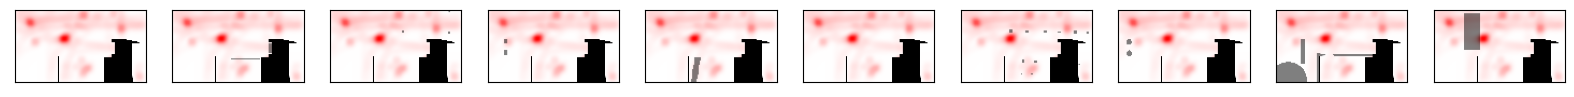

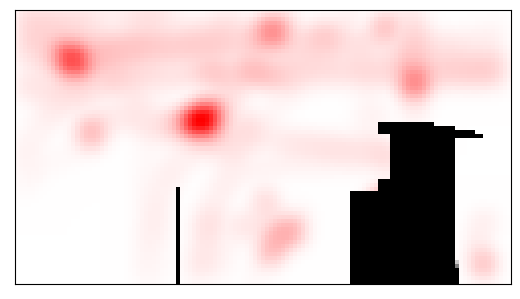

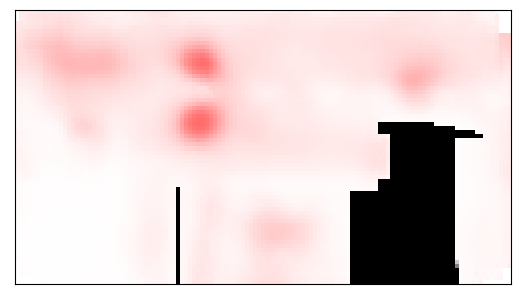

KL-divergence average: 0.20772018246953985
KL-divergence std: 0.1583532147869081
stanford_coupa3
Reduced map found
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass', 'intersection']


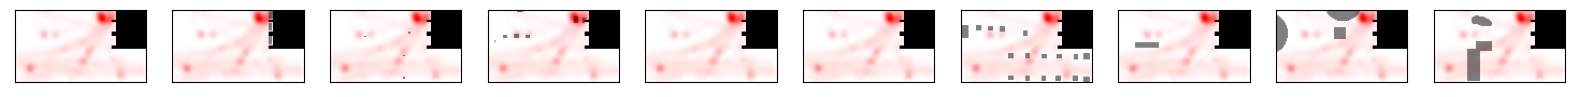

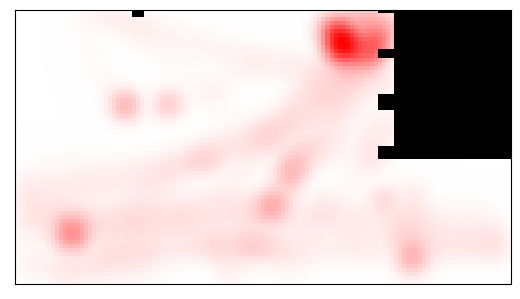

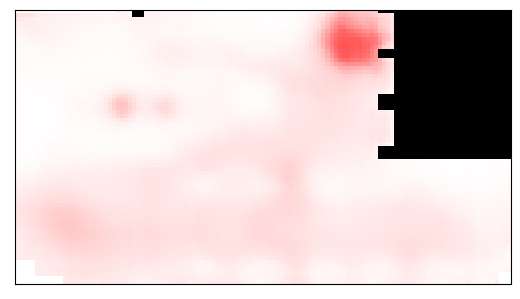

KL-divergence average: 0.14766870568863702
KL-divergence std: 0.10133747100051566
stanford_hyang1
Reduced map found
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass', 'intersection']


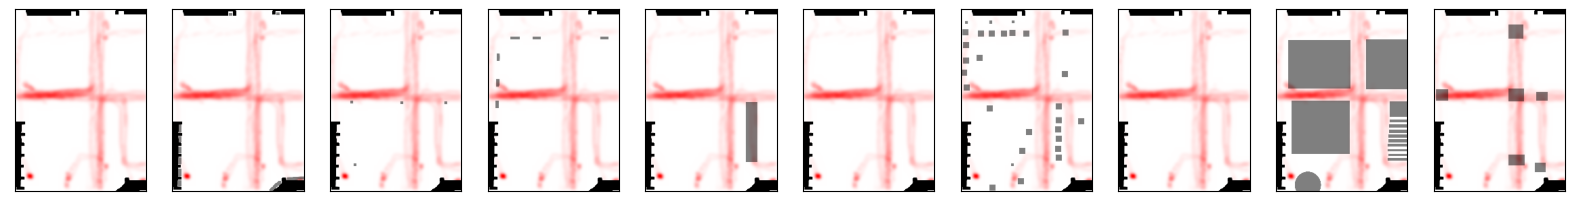

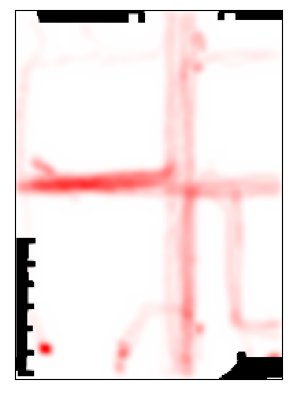

/tmp/ipykernel_1701274/1683487707.py:153: RuntimeWarning: invalid value encountered in divide
  data_aux = data_aux/sum(sum(data_aux))


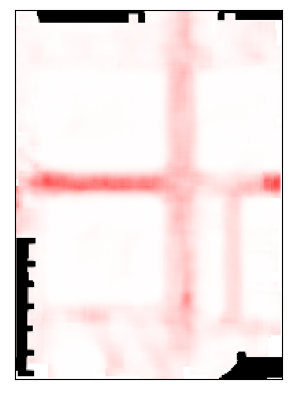

KL-divergence average: 0.8761182977819806
KL-divergence std: 1.2394202940967118
stanford_gates2
Reduced map found
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass', 'intersection']


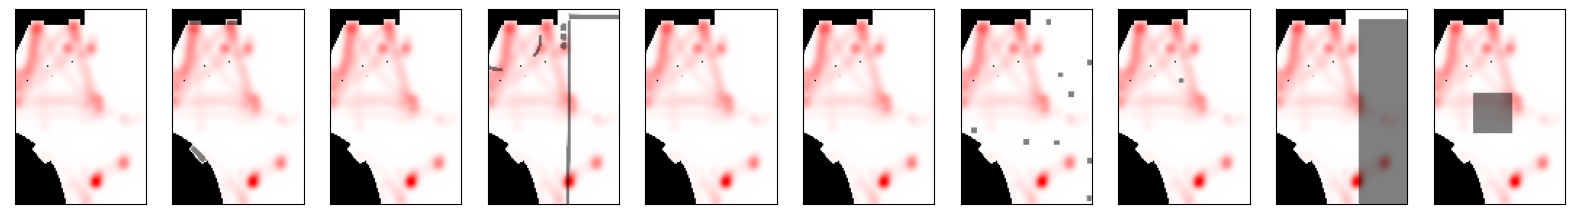

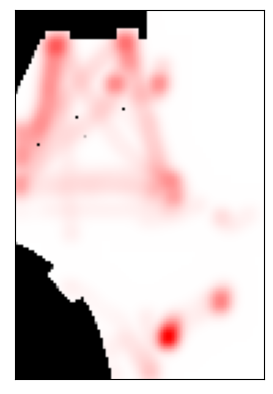

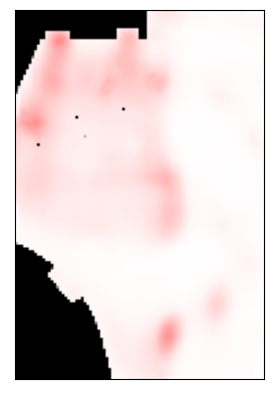

KL-divergence average: 0.4847620542429573
KL-divergence std: 0.603640561961833
Mean KL-divergence: 0.6210979680163775
Std KL-divergence: 0.7985114936373227


In [6]:
kl1 = []

for map_count, map_name in enumerate(map_list):
  print(map_name)

  lines = 0
  try:
    with open('maps/semantics/'+map_name+'/'+map_name+'-reduced.csv') as f:
      print('Reduced map found')
      lines = f.readlines()
      
  except FileNotFoundError:
    with open('maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
      print('Using original map')
      lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  for lab_class in sem_dict:
    lines = 0
    try:
      with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'-reduced.csv') as f:
        lines = f.readlines()

      hh = len(lines)
      ww = len(lines[0].split(','))

      if hh != h or ww != w:
        print(f'h: {h}\tw: {w}')
        print(f'h: {hh}\tw: {ww}')
        raise SystemExit("ERROR: Different sizes!!")

      # Converts data to a list of integers
      for line in lines:
        map.extend([int(c) for c in line.split(',')])
    
    except FileNotFoundError:
      try:
        with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
          lines = f.readlines()

        hh = len(lines)
        ww = len(lines[0].split(','))

        if hh != h or ww != w:
          print(f'h: {h}\tw: {w}')
          print(f'h: {hh}\tw: {ww}')
          raise SystemExit("ERROR: Different sizes!!")

        # Converts data to a list of integers
        for line in lines:
          map.extend([int(c) for c in line.split(',')])

      except FileNotFoundError:
        for i in range(h):
          for j in range(w):
            map.extend([255])

  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/red)),int(math.ceil(w/red)),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red,red), np.max)

  # print(map.shape)
  h, w, _ = map.shape

# -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-new.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([int(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  sigma = 10.0
  data = skimage.filters.gaussian(data, sigma=(sigma, sigma), channel_axis=-1)
  data = skimage.measure.block_reduce(data, (red,red), np.max)
  data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))
  data = data*(map[:,:,0]>0)

  # print(data.shape)
  hd, wd = data.shape

  print(sem_dict)
  plt.figure(figsize=(20,5))
  for i in range(len(sem_dict)):
    ax = plt.subplot(1, len(sem_dict), i+1)
    alp = 0.5
    ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2),np.multiply(np.stack((map[:,:,i+1],map[:,:,i+1],map[:,:,i+1]),axis=2)*alp+(1-alp), np.stack((np.full(data.shape,1),1-data,1-data),axis=2))), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

  ax = plt.subplot(111)
  ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data.shape,1),1-data,1-data),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  # -----------------------------------------------------------------------------------
  # Random sample 32x32 windows in map
  n_crops = 500
  inserted = 0
  crops = np.zeros((n_crops,2),dtype=int)
  selections = np.zeros((h,w))
  for i in range(n_crops):
    background = np.zeros((h,w))
    flag = True
    while flag:
      aux_x = int(random.random()*(w-div+1))
      aux_y = int(random.random()*(h-div+1))
      flag = False
      # print(f'INSERTED: {inserted}  ->  x: {aux_x} and y: {aux_y}')
      # for z in range(inserted):
      #   if abs(aux_x-crops[z,0])<int(div/10) and abs(aux_y-crops[z,1])<int(div/10):
      #     # print('too close')
      #     flag = True
    crops[i,0] = aux_x
    crops[i,1] = aux_y
    selections = selections+cv2.rectangle(background,(crops[i,0],crops[i,1]),(crops[i,0]+div-1,crops[i,1]+div-1),(1,0,0),-1)
    inserted = inserted + 1
  selections = 1/selections

  # -----------------------------------------------------------------------------------
  # creating subplot and figure
  ax = plt.subplot(111)
  data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))
  kls = []
  for i in range(n_crops):
    submap = map[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div,:]
    subdata = model.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
    subdata = np.squeeze(subdata,axis=0)
    data_pred[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    # Calculate the KL-divergence
    data_aux = data[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    data_aux = data_aux/sum(sum(data_aux))
    subdata_pred = subdata/sum(sum(subdata))
    kl = 0
    for i in range(data_aux.shape[0]):
        for j in range(data_aux.shape[1]):
            if data_aux[i,j] > 0 and subdata[i,j] > 0:
                kl = kl + data_aux[i,j]*math.log(data_aux[i,j]/subdata_pred[i,j])
    kls.append(kl)
  plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  # print(f'KL-divergences: {kls}')
  print(f'KL-divergence average: {np.average(kls)}')
  print(f'KL-divergence std: {np.std(kls)}')
  kl1 = np.append(kl1,kl)

print(f'Mean KL-divergence: {np.mean(kl1)}')
print(f'Std KL-divergence: {np.std(kl1)}')

## Model 2 testing

In [ ]:
kl1 = []

for map_count, map_name in enumerate(map_list):
  print(map_name)

  lines = 0
  with open('maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
    lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  for lab_class in sem_dict:
    lines = 0
    try:
      with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
        lines = f.readlines()

      hh = len(lines)
      ww = len(lines[0].split(','))

      if hh != h or ww != w:
        print(f'h: {h}\tw: {w}')
        print(f'h: {hh}\tw: {ww}')
        raise SystemExit("ERROR: Different sizes!!")

      # Converts data to a list of integers
      for line in lines:
        map.extend([int(c) for c in line.split(',')])

    except FileNotFoundError:
      for i in range(h):
        for j in range(w):
          map.extend([255])

  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/red)),int(math.ceil(w/red)),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red,red), np.max)
  h, w, _ = map.shape

  diff_h = int((h-div*int(h/div))/2)
  r_h = int((h-div*int(h/div))%2) + diff_h
  diff_w = int((w-div*int(w/div))/2)
  r_w = int((w-div*int(w/div))%2) + diff_w
  map = map[r_h:-diff_h:,r_w+diff_w:,:]

  # print(map.shape)
  h, w, _ = map.shape

# -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-vel.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([float(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  sigma = 10.0
  data = skimage.filters.gaussian(data, sigma=(sigma, sigma), channel_axis=-1)
  data = skimage.measure.block_reduce(data, (red,red), np.max)
  data = data[r_h:-diff_h,r_w+diff_w:]
  data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))

  # print(data.shape)
  hd, wd = data.shape

  print(sem_dict)
  plt.figure(figsize=(20,5))
  for i in range(len(sem_dict)):
    i = i+1
    ax = plt.subplot(1, len(sem_dict), i)
    alp = 0.5
    ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2),np.multiply(np.stack((map[:,:,i],map[:,:,i],map[:,:,i]),axis=2)*alp+(1-alp), np.stack((np.full(data.shape,1),1-data,1-data),axis=2))), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

  ax = plt.subplot(111)
  ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data.shape,1),1-data,1-data),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  # -----------------------------------------------------------------------------------
  # creating subplot and figure
  ax = plt.subplot(111)
  data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

  step = int(32/4)
  for i in np.arange((w/step+int(div/step-1))*(h/step+int(div/step-1))):
    c = int(i%(w/step+int(div/step-1))) - int(div/step-1)*0
    r = int(i/(w/step+int(div/step-1))) - int(div/step-1)*0
    submap = map[max(step*r,0):step*r+div, max(step*c,0):step*c+div,:]
    subdata = model1.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
    subdata = np.squeeze(subdata,axis=0)
    data_pred[max(step*r,0):step*r+div, max(step*c,0):step*c+div] += subdata*1/(int(div/step)*int(div/step))
  plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-(data_pred),1-(data_pred)),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  data = data/sum(sum(data))
  data_pred = data_pred/sum(sum(data_pred))
  kl = 0
  for i in range(data.shape[0]):
      for j in range(data.shape[1]):
          if data[i,j] > 0 and data_pred[i,j] > 0:
              kl = kl + data[i,j]*math.log2(data[i,j]/data_pred[i,j])
  print(f'KL-divergence: {kl}')
  kl1 = np.append(kl1,kl)

print(f'Mean KL-divergence: {np.mean(kl1)}')

## Model 3 testing

In [ ]:
kl1 = []

for map_count, map_name in enumerate(map_list):
  print(map_name)

  lines = 0
  with open('maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
    lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  for lab_class in sem_dict:
    lines = 0
    try:
      with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
        lines = f.readlines()

      hh = len(lines)
      ww = len(lines[0].split(','))

      if hh != h or ww != w:
        print(f'h: {h}\tw: {w}')
        print(f'h: {hh}\tw: {ww}')
        raise SystemExit("ERROR: Different sizes!!")

      # Converts data to a list of integers
      for line in lines:
        map.extend([int(c) for c in line.split(',')])

    except FileNotFoundError:
      for i in range(h):
        for j in range(w):
          map.extend([255])

  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/red)),int(math.ceil(w/red)),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red,red), np.max)
  h, w, _ = map.shape

  diff_h = int((h-div*int(h/div))/2)
  r_h = int((h-div*int(h/div))%2) + diff_h
  diff_w = int((w-div*int(w/div))/2)
  r_w = int((w-div*int(w/div))%2) + diff_w
  map = map[r_h:-diff_h:,r_w+diff_w:,:]

  # print(map.shape)
  h, w, _ = map.shape

# -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-stop.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([float(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  sigma = 10.0
  data = skimage.filters.gaussian(data, sigma=(sigma, sigma), channel_axis=-1)
  data = skimage.measure.block_reduce(data, (red,red), np.max)
  data = data[r_h:-diff_h,r_w+diff_w:]
  data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))

  # print(data.shape)
  hd, wd = data.shape

  print(sem_dict)
  plt.figure(figsize=(20,5))
  for i in range(len(sem_dict)):
    i = i+1
    ax = plt.subplot(1, len(sem_dict), i)
    alp = 0.5
    ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2),np.multiply(np.stack((map[:,:,i],map[:,:,i],map[:,:,i]),axis=2)*alp+(1-alp), np.stack((np.full(data.shape,1),1-data,1-data),axis=2))), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

  ax = plt.subplot(111)
  ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data.shape,1),1-data,1-data),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  # -----------------------------------------------------------------------------------
  # creating subplot and figure
  ax = plt.subplot(111)
  data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

  step = int(32/4)
  for i in np.arange((w/step+int(div/step-1))*(h/step+int(div/step-1))):
    c = int(i%(w/step+int(div/step-1))) - int(div/step-1)*0
    r = int(i/(w/step+int(div/step-1))) - int(div/step-1)*0
    submap = map[max(step*r,0):step*r+div, max(step*c,0):step*c+div,:]
    subdata = model2.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
    subdata = np.squeeze(subdata,axis=0)
    data_pred[max(step*r,0):step*r+div, max(step*c,0):step*c+div] += subdata*1/(int(div/step)*int(div/step))
  plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-(data_pred),1-(data_pred)),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  data = data/sum(sum(data))
  data_pred = data_pred/sum(sum(data_pred))
  kl = 0
  for i in range(data.shape[0]):
      for j in range(data.shape[1]):
          if data[i,j] > 0 and data_pred[i,j] > 0:
              kl = kl + data[i,j]*math.log2(data[i,j]/data_pred[i,j])
  print(f'KL-divergence: {kl}')
  kl1 = np.append(kl1,kl)


print(f'Mean KL-divergence: {np.mean(kl1)}')